# Face Recognition Project

Для начала познакомимся с тем, как работает стандартный пайплан для распознавания лиц. Это не одна нейросеть, которая делает всю работу: это целых три отдельных стадии.



Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.


Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

Давайте обсудим все этапы подробнее:

Пусть мы получили кадр с камеры наблюдения, на котором мы хотим распознать лица. Этот кадр может выглядеть как-то так:

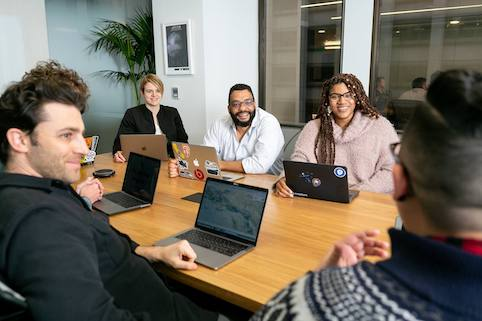

Первый этап обработки фото — детекция лиц на нем. Результат детекции может выглядеть примерно так:

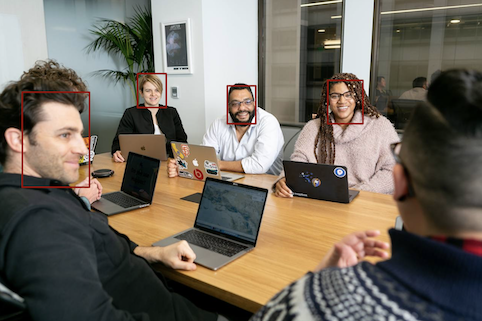

Для детекции лиц на фото может использоваться модель (например, нейросеть), обученная на задачу детекции лиц людей.

После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

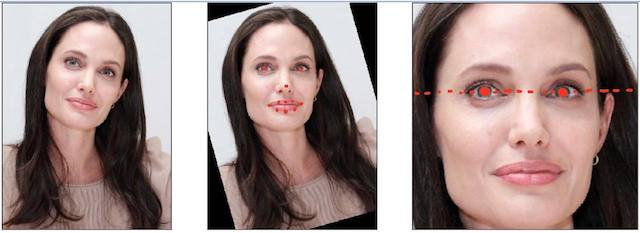

Таким образом, после второго этапа лица выглядят как-то так:

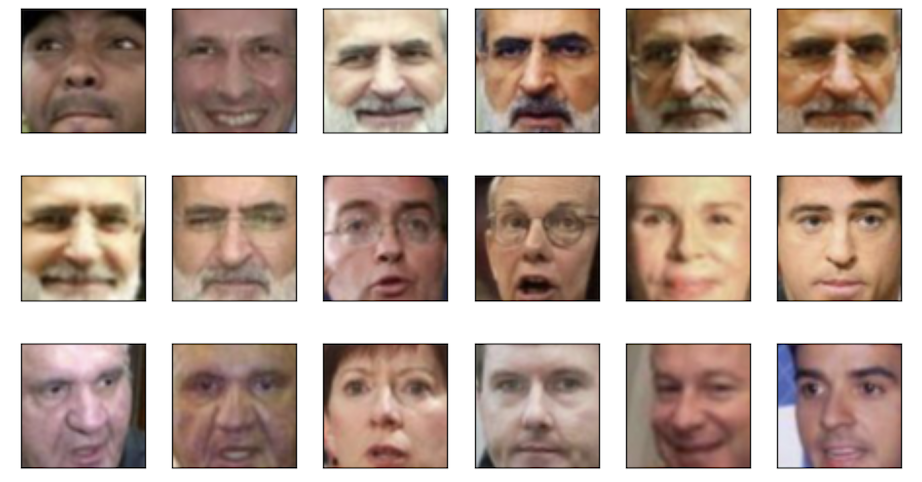



На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

Зачем нужна стадия выравнивания: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

Практика подтверждает, что это сильно улучшает эффективность модели: без стадии выравнивания практически невозможно обучить хорошую систему распознавания лиц. Точнее, возможно, но только если есть очень-очень-очень много обучающих данных. Больше, чем практически у всех даже больших компаний.




Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется косинусное расстояние (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"


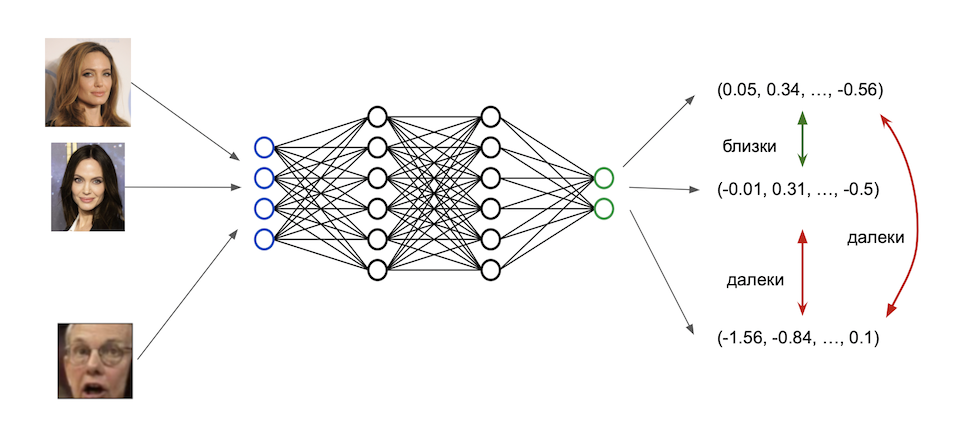

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем ниже в ноутбуке). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

    Лосс-функция в этом случае выглядит так:
    
$$L = D(anchor, positive) - D(anchor, negative)$$

У contrastive loss тоже есть недостаток: его достаточно сложно настроить (подобрать к нему гиперпараметры).

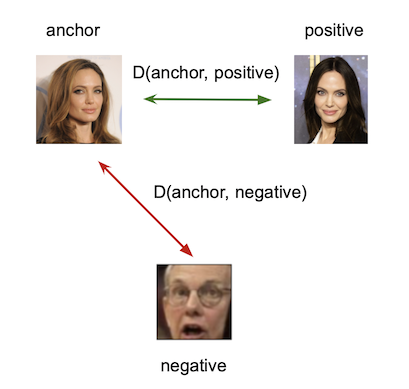



Вот так устроен пайплайн распознавания лиц, который мы хотим получить. Заметим, что все три части пайплайна обучаются отдельно.

    первая часть — это просто задача детекции;
    вторая часть — задача выравнивания фотографии лица;
    третья часть — задача распознавания лица по выровненной фотографии.



## 1. Постройка сети для распознавания лиц



При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.

Чтобы это исправить, придумали новую метрику: identification rate. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

    посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
    посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
    посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
    Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
    Зафиксируем FPR (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
    Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как пороговое расстояние.
    Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.


In [6]:
import numpy as np
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import os
import cv2
from PIL import Image
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from skimage import io, transform
from skimage.transform import resize
from copy import deepcopy
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
img_names = os.listdir('./celebA_train_500/celebA_imgs/')
print(f'Всего {len(img_names)} картинок')

Всего 23948 картинок


In [3]:
f = open('celebA_train_500/celebA_anno.txt')
lines = f.readlines()
dict1 = dict()
for i in range(0,500):
    dict1[i] = []
for i in lines:
    z = i.split()
    dict1[int(z[1])].append(z[0])

a = {1:[2,3]}
names = [dict1[i] for i in dict1]
cnts = [len(dict1[i]) for i in dict1]
df = pd.DataFrame({'images':names,'img_counts':cnts})
df

,images,img_counts
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
495,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
496,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
497,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22
498,"[000518.jpg, 001543.jpg, 003209.jpg, 008966.jp...",30


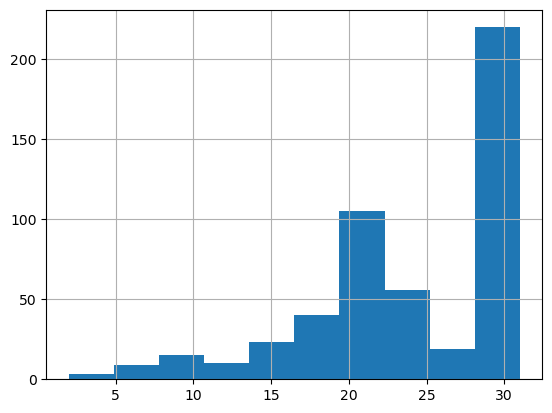

In [4]:
df['img_counts'].hist();

Выведем 5 рандомных картинок людей

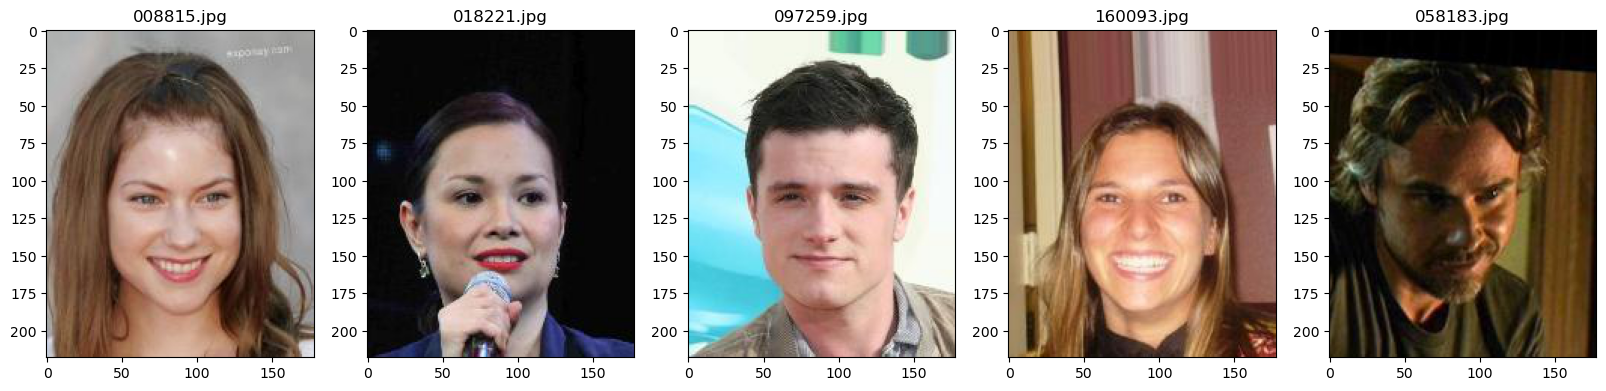

In [5]:
a = [img_names[i] for i in [np.random.randint(0,len(img_names)) for i in range(5)]]
imgs = []
for img in a:
    img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
    imgs.append(np.array(img))

f, axes= plt.subplots(1, len(imgs), figsize=(4*len(imgs),5))
for i, axis in enumerate(axes):
    axes[i].grid(False)
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(a[i])
plt.show()

Все глаза действительно на одной линии

### Непосредственно обучение нейронной сети + создание датасета

In [10]:
def get_paths(dataset_type='train'):
    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt')
    lines = f.readlines()
    f.close()

    lines = [i.strip().split() for i in lines]
    lines = [i[0] for i in lines if int(i[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)

class celebA(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 

        sample = {
            'image': self.transform(image),
            'label': label,
        }
        
        return (sample['image'], sample['label'])

    def get_photos(self, person_number):
        photos = []
        for i, j in enumerate(self.labels):
            if j == person_number:
                photos.append(self.images[i])
        if len(photos) != 0:
            photos = torch.stack([self.transform(Image.open(x)) for x in photos])
        else:
            photos = torch.Tensor()
        return photos

In [11]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform2 = transforms.Compose([
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


train_data = celebA('train', transform2)
val_data = celebA('val', transform)
test_data = celebA('test', transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
pip install timm

^C
Note: you may need to restart the kernel to use updated packages.


In [10]:
import timm

model = timm.create_model('efficientnet_b0', pretrained=True)

num_classes = 500
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=num_classes, bias=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Файн-тюним модель, используя кросс-энтропию

In [11]:
def train(model, train_loader, val_loader, optimizer, epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    train_losses, val_losses, val_full_acc, train_full_acc = [], [], [], []
    best_acc = 0.0
    loss_fn = nn.CrossEntropyLoss()
    best_model_weights = deepcopy(model.state_dict())

    for epoch in range(epochs):
        print('Эпоха %d из %d' % (epoch+1, epochs))        

        model.train()
        current_train_loss = 0
        current_train_correct = 0

        for inputs, labels in train_loader:
            X_batch = inputs.to(device)
            Y_batch = labels.to(device)

            optimizer.zero_grad()

            Y_pred = model(X_batch)
            preds = torch.argmax(Y_pred, 1)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            current_train_loss += loss.item() * X_batch.size(0)
            current_train_correct += torch.sum(preds == Y_batch)

        train_loss = current_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_acc = current_train_correct / len(train_loader.dataset)
        train_full_acc.append(train_acc)
        print('train acc = {:.2f}%'.format(train_acc.item()*100))

        model.eval()
        current_val_loss = 0
        current_val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                X_val = inputs.to(device)
                Y_val = labels.to(device)

                outputs = model(X_val)
                val_loss = loss_fn(outputs, Y_val)
                preds = torch.argmax(outputs, 1)
                current_val_correct += torch.sum(preds == Y_val)
                current_val_loss += val_loss.item() * X_val.size(0)
                
        val_acc = current_val_correct / len(val_loader.dataset)
        val_loss = current_val_loss / len(val_loader.dataset)
          
        print('val acc = {:.2f}%'.format(val_acc.item() * 100))
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_weights = deepcopy(model.state_dict())

    return best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc


In [37]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, optimizer, epochs=15)

Эпоха 1 из 15
train acc = 99.23%
val acc = 75.83%
Эпоха 2 из 15
train acc = 99.95%
val acc = 76.30%
Эпоха 3 из 15
train acc = 99.93%
val acc = 77.00%
Эпоха 4 из 15
train acc = 99.99%
val acc = 77.05%
Эпоха 5 из 15
train acc = 99.99%
val acc = 77.53%
Эпоха 6 из 15
train acc = 99.99%
val acc = 77.16%
Эпоха 7 из 15
train acc = 99.99%
val acc = 77.64%
Эпоха 8 из 15
train acc = 99.99%
val acc = 77.37%
Эпоха 9 из 15
train acc = 99.96%
val acc = 78.17%
Эпоха 10 из 15
train acc = 99.99%
val acc = 78.12%
Эпоха 11 из 15
train acc = 99.98%
val acc = 77.90%
Эпоха 12 из 15
train acc = 99.96%
val acc = 78.06%
Эпоха 13 из 15
train acc = 99.99%
val acc = 78.17%
Эпоха 14 из 15
train acc = 99.99%
val acc = 78.49%
Эпоха 15 из 15
train acc = 99.99%
val acc = 78.54%


Ура, победа ＼(￣▽￣)／

Я пробовал обучать на ResNet50, InceptionV3, после чего попробовал EfficientNet_b0, выходило 65% на валидации, и наконец-то получилось, используя EfficientNet_b3. Сначала обучал с lr = 0.001, потом дообучал с lr = 0.0001

In [168]:
weights_path = "best_model_weights.pth"

# Сохранение весов
torch.save(best_model_weights, weights_path)

print("Веса лучшей модели сохранены в", weights_path)

Веса лучшей модели сохранены в best_model_weights.pth


In [169]:
best_model = timm.create_model('efficientnet_b3', pretrained=True)

num_classes = 500
best_model.classifier = nn.Linear(in_features=best_model.classifier.in_features, out_features=num_classes, bias=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model.to(device);

In [170]:
loaded_weights = torch.load(weights_path)

best_model.load_state_dict(loaded_weights)

print("Веса лучшей модели успешно загружены из", weights_path)


Веса лучшей модели успешно загружены из best_model_weights.pth


In [46]:
train_full_acc_cpu = []
for i in train_full_acc:
    train_full_acc_cpu.append(i.cpu().numpy())

val_full_acc_cpu = []
for i in val_full_acc:
    val_full_acc_cpu.append(i.cpu().numpy())

График точности на обучающем и валидационном наборах данных

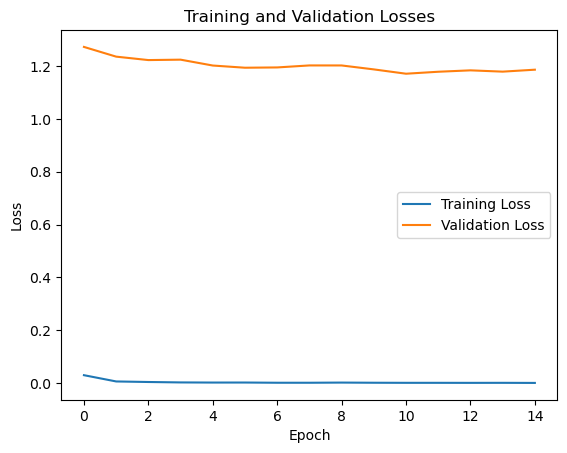

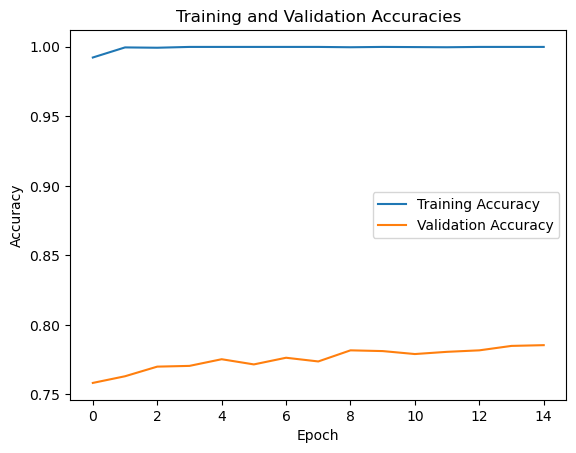

In [47]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

plt.plot(train_full_acc_cpu, label='Training Accuracy')
plt.plot(val_full_acc_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

Оценю точность на тестовом наборе данных

In [61]:
best_model = timm.create_model('efficientnet_b3', pretrained=True)
num_classes = 500
best_model.classifier = nn.Linear(best_model.classifier.in_features, num_classes)
best_model.load_state_dict(best_model_weights)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device).eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model.to(device)(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Правильных ответов на тесте: {correct} из {total} ')
print(f'Accuracy на тесте: {accuracy:.2f}%')

Правильных ответов на тесте: 1237 из 1589 
Accuracy на тесте: 77.85%


Рассчитаю косинусное расстояние. Сначала уберу последний слой из обученной сети. Затем получу эмбеддинги для некоторых изображений из обучающего набора и изображений из тестового набора. Вычислите косинусное расстояние между эмбеддингами, соответствующими изображениям одного и того же человека, и эмбеддингами разных людей

Отключу последний слой и переведу в режим оценки

In [63]:
best_model.classify = False

best_model.eval();

Вычислю эмбеддинги для 50^2 пар изображений, при этом буду брать каждое 2е изображение

In [74]:
n_ppl = 100
all_similarity_results = []

best_model.eval()
with torch.no_grad():
    for i in range(1,n_ppl,2):
        similarity_results_for_person = []
        train_img_i = best_model(train_data.get_photos(i).to(device))
        for j in range(1,n_ppl,2):
            if (len(test_data.get_photos(j)) != 0) and (len(train_data.get_photos(i)) != 0):
                test_img_j = best_model(test_data.get_photos(j).to(device))
                similarity_results_for_person.append(cosine_similarity(train_img_i.cpu(), test_img_j.cpu()).mean())
            else:
                similarity_results_for_person.append(0.0)
        all_similarity_results.append(similarity_results_for_person)
        clear_output(wait=True)

similarity_df = pd.DataFrame(np.array(all_similarity_results))
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.968974,0.939695,0.937041,0.937077,0.946853,0.907062,0.915582,0.926834,0.928220,0.913385,...,0.943987,0.924718,0.899658,0.939511,0.949220,0.932571,0.940315,0.931963,0.945202,0.918889
1,0.935993,0.959224,0.935777,0.928446,0.931246,0.928320,0.938706,0.912842,0.918938,0.909333,...,0.933790,0.931927,0.916347,0.907803,0.929124,0.895680,0.936262,0.951283,0.923073,0.931287
2,0.941825,0.936793,0.975266,0.922584,0.936791,0.915910,0.936936,0.897649,0.938977,0.922324,...,0.930585,0.930406,0.906577,0.925223,0.914359,0.929275,0.942562,0.948703,0.922603,0.909795
3,0.923498,0.917812,0.927083,0.980726,0.920800,0.931049,0.902452,0.939659,0.909272,0.932375,...,0.954991,0.909896,0.883502,0.927386,0.917450,0.919033,0.940508,0.916354,0.915423,0.911430
4,0.948737,0.927599,0.935693,0.922819,0.976355,0.918205,0.925604,0.923505,0.939966,0.913912,...,0.934474,0.942892,0.908318,0.940565,0.943399,0.919636,0.932631,0.929581,0.941682,0.921534
5,0.909321,0.929685,0.930249,0.928970,0.924391,0.977798,0.942708,0.928977,0.912640,0.912136,...,0.934772,0.934138,0.917499,0.919973,0.910770,0.878857,0.923589,0.922434,0.927383,0.925304
6,0.902774,0.930161,0.926879,0.910208,0.921457,0.935327,0.960277,0.930037,0.918884,0.918993,...,0.922511,0.948149,0.926758,0.922797,0.922675,0.888318,0.908936,0.941232,0.926711,0.914477
7,0.912403,0.906587,0.898351,0.940689,0.916713,0.925216,0.906623,0.981670,0.899657,0.925043,...,0.928122,0.932972,0.883911,0.937263,0.938727,0.886487,0.906074,0.901380,0.931547,0.920855
8,0.924629,0.900411,0.916231,0.909088,0.928121,0.883072,0.889442,0.895235,0.969831,0.912052,...,0.916390,0.913500,0.902546,0.921394,0.917121,0.943368,0.920357,0.913103,0.930857,0.873688
9,0.907642,0.908587,0.912885,0.937742,0.918513,0.906035,0.896998,0.920199,0.918582,0.974286,...,0.941770,0.915309,0.888424,0.937527,0.917684,0.928106,0.936719,0.915835,0.906576,0.926882


Получил огромный датафрейм, теперь для удобства переведу его в тепловую карту

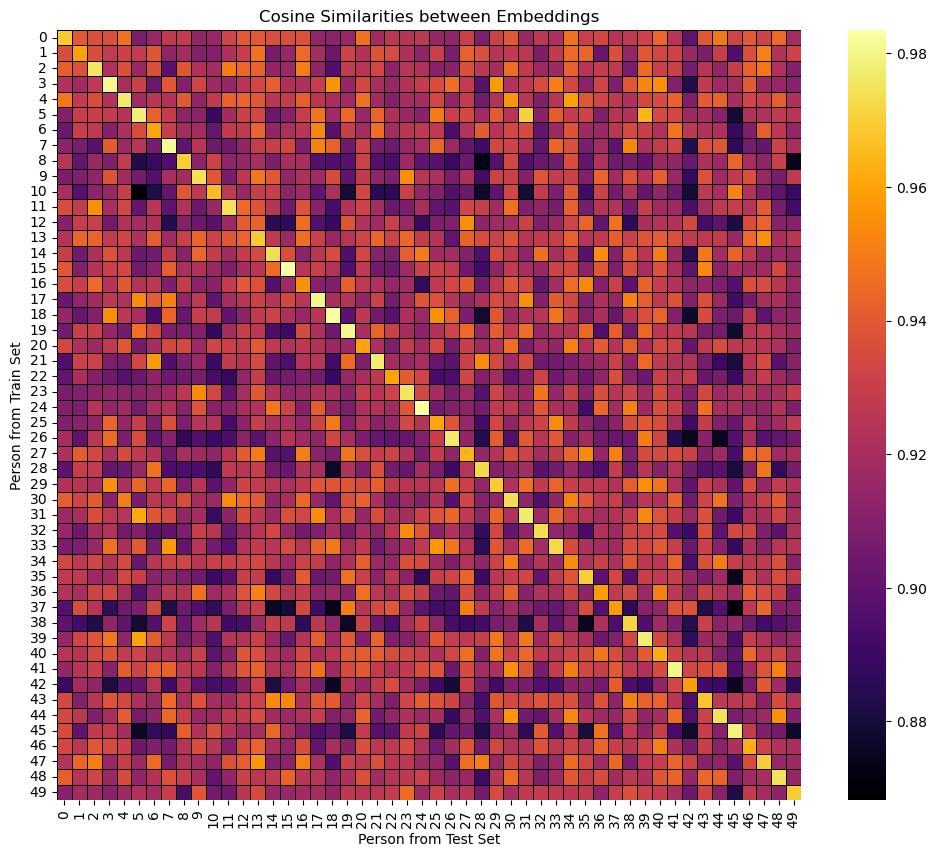

In [76]:
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='inferno', linewidths=0.5, linecolor='black')
plt.xlabel('Person from Test Set')
plt.ylabel('Person from Train Set')
plt.title('Cosine Similarities between Embeddings')
plt.show()

## 2. Реализация TPR@FPR = 0.01

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

In [150]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [151]:
len(distractors_img_names),len(query_img_names),len(query_dict)

(2001, 1222, 51)

In [152]:
distractors_img_names

['001462.jpg',
 '001463.jpg',
 '001476.jpg',
 '001477.jpg',
 '001488.jpg',
 '001489.jpg',
 '001501.jpg',
 '001502.jpg',
 '001503.jpg',
 '001515.jpg',
 '001516.jpg',
 '001529.jpg',
 '001648.jpg',
 '001660.jpg',
 '001661.jpg',
 '001663.jpg',
 '001675.jpg',
 '001700.jpg',
 '001703.jpg',
 '001714.jpg',
 '001717.jpg',
 '001728.jpg',
 '001729.jpg',
 '001844.jpg',
 '001846.jpg',
 '001847.jpg',
 '001850.jpg',
 '001852.jpg',
 '001853.jpg',
 '001878.jpg',
 '001884.jpg',
 '001885.jpg',
 '001887.jpg',
 '001890.jpg',
 '001891.jpg',
 '001893.jpg',
 '001918.jpg',
 '001924.jpg',
 '001927.jpg',
 '001930.jpg',
 '001932.jpg',
 '001933.jpg',
 '002008.jpg',
 '002020.jpg',
 '002022.jpg',
 '002023.jpg',
 '002034.jpg',
 '002036.jpg',
 '002037.jpg',
 '002142.jpg',
 '002143.jpg',
 '002156.jpg',
 '002157.jpg',
 '002180.jpg',
 '002181.jpg',
 '002194.jpg',
 '002195.jpg',
 '002208.jpg',
 '002209.jpg',
 '002220.jpg',
 '002221.jpg',
 '002222.jpg',
 '002235.jpg',
 '002236.jpg',
 '002340.jpg',
 '002342.jpg',
 '002354.j

In [153]:
for i in range(len(distractors_img_names)):
    distractors_img_names[i] = './celebA_ir/celebA_distractors/' + distractors_img_names[i]

In [154]:
for i in range(len(query_img_names)):
    query_img_names[i] = './celebA_ir/celebA_query/' + query_img_names[i]

In [155]:
class celebA_ir_Dataset(Dataset):
    def __init__(self, images_list, 
                 transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                               ])):
        self.images = images_list
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def get_tensors(self):        
        images = torch.stack([self.transform(Image.open(img_name)) for img_name in self.images])
        return images

    def __getitem__(self, idx):        
        img_name = self.images[idx]
        image = Image.open(img_name) 
        
        return self.transform(image), idx

In [156]:
def compute_embeddings(model, images_list):
    '''
    compute embeddings from the trained model for list of images.
    params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
    output:
    list: list of model embeddings. Each embedding corresponds to images 
          names from images_list
    '''
    data = celebA_ir_Dataset(images_list)

    model.to(device)

    loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=32, shuffle=False)

    model.eval()
    embeddings = []
    with torch.no_grad():
        for x in loader:
            outputs = model(x.to(device))
            embeddings.append(outputs.cpu())
    return torch.cat(embeddings)

In [157]:
query_embeddings = compute_embeddings(best_model, query_img_names)
distractors_embeddings = compute_embeddings(best_model, distractors_img_names)

In [158]:
distractors_embeddings.size(), query_embeddings.size()

(torch.Size([2001, 500]), torch.Size([1222, 500]))

In [159]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
    '''
    for person_class in query_dict:
        if query_dict[person_class][0] not in query_img_names:
            PATH = './celebA_ir/celebA_query/{}'
        else:
            PATH = '{}'
        break

    full_embeddings = torch.Tensor()

    for person_class in query_dict:
        images = [PATH.format(x) for x in query_dict[person_class]] 
        person_embeddings = []
        for image_path in images:
            person_embeddings.append(
              torch.Tensor(query_embeddings[query_img_names.index(image_path)])
              )
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
            result = 0.0
        else:
            person_embeddings = torch.stack(person_embeddings)
            result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
            df = pd.DataFrame(result)

            df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
            useful_result = df[~np.isnan(df)]

            useful_result = torch.Tensor(useful_result).view(-1)
            full_embeddings = torch.cat((full_embeddings, useful_result))
        results = [i.item() for i in full_embeddings]
    plt.hist(results)
    plt.show()
    print('Count of cosine similarities between positive pairs from query:', len(results))
    return results

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding 
                    to different people from query list
    '''
    for person_class in query_dict:
        if query_dict[person_class][0] not in query_img_names:
            PATH = './celebA_ir/celebA_query/{}'
        else:
            PATH = '{}'
        break

    full_embeddings = torch.Tensor()
    class_counter = []

    k = 0
    for person_class in query_dict:
        k += 1
        images = [PATH.format(x) for x in query_dict[person_class]] 
        class_counter.extend([person_class for i in range(len(images))])

        person_embeddings = []
        for image_path in images:
            person_embeddings.append(
                torch.Tensor(query_embeddings[query_img_names.index(image_path)])
          )
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
            result = 0.0
        else:
            person_embeddings = torch.stack(person_embeddings)
            full_embeddings = torch.cat((full_embeddings, person_embeddings))
        clear_output(wait=True)

    all_data = pd.DataFrame(data={'class': class_counter, 'embeddings': list(full_embeddings)})
    results = cosine_similarity(full_embeddings, full_embeddings)
    results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

    k = 0
    for i in results:
        k += 1
        results.loc[i, i] = np.nan
        clear_output(wait=True)

    df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
    useful_result = df[~np.isnan(df)]
    plt.hist(useful_result)
    plt.show()
    print('Count of cosine similarities between negative pairs from query:', len(useful_result))
    return useful_result

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
    list of floats: similarities between pairs of people (q, d), where q is 
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
    '''
    results = cosine_similarity(query_embeddings, distractors_embeddings)
    results = results.reshape(-1)
    plt.hist(results)
    plt.show()
    print('Count of cosine similarities between negative pairs from query and distractors:', len(results))
    return results

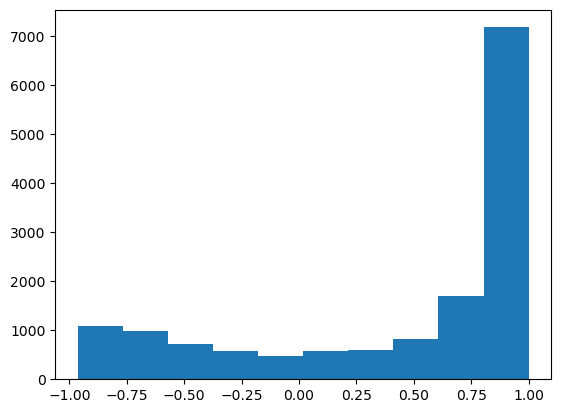

Count of cosine similarities between positive pairs from query: 14721


In [160]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)

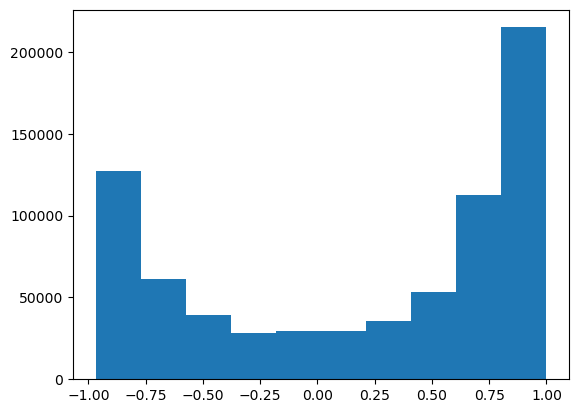

Count of cosine similarities between negative pairs from query: 731310


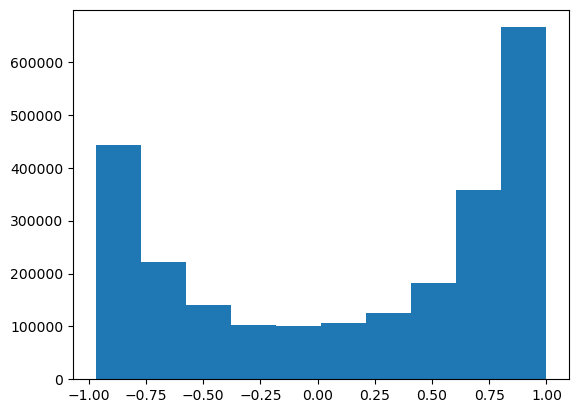

Count of cosine similarities between negative pairs from query and distractors: 2445222


In [161]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

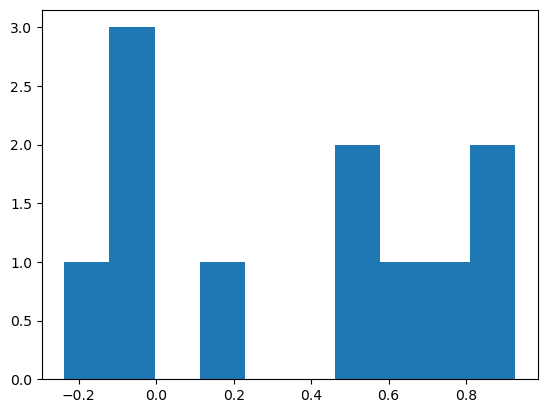

Count of cosine similarities between negative pairs from query: 11


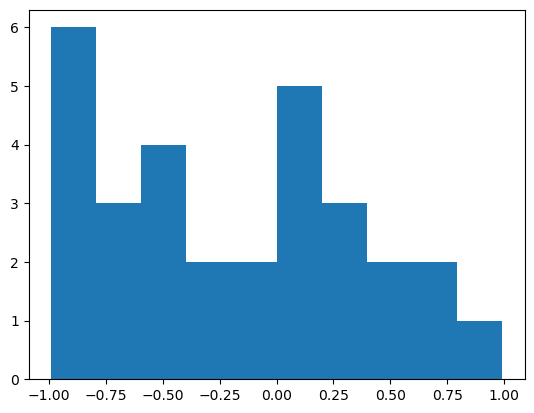

Count of cosine similarities between negative pairs from query and distractors: 30


In [162]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [163]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Наконец-то, все работает!!

In [164]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs 
                              from query and distractors
    fpr: false positive rate at which to compute TPR
    output: 
    float: threshold for given fpr 
    float: TPR at given FPR
    '''
    cosine_query_pos = torch.Tensor(cosine_query_pos)
    cosine_query_neg = torch.Tensor(cosine_query_neg)
    cosine_query_distractors = torch.Tensor(cosine_query_distractors)

    false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
    N = round(fpr * len(false_pairs))
    false_pairs = torch.sort(false_pairs, descending = True)[0]
    threshold = false_pairs[N]
    TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
    return threshold.item(), TPR

In [165]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [166]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

И сам подсчет IR metric также работает

In [167]:
thresholds = []
tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                      cosine_query_distractors, fpr=fpr)
    thresholds.append(x)
    tpr.append(y)

display(thresholds)
display(tpr)

[0.4060978293418884,
 0.8557851314544678,
 0.9082903265953064,
 0.9362092018127441]

[0.6600095102234903,
 0.4241559676652401,
 0.3101691461177909,
 0.21343658718837036]

Странно, до этого выдавало результаты лучше, но сейчас выдает такой маленький tpr

## 3. Реализация TripletLoss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


In [7]:
class TripletLoss_celebADataset(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)
        self.dataset_type = dataset_type
        
        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()

        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}

        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform
        self.df = pd.DataFrame(data={'original': self.images, 'label': self.labels})

        triplet_df = pd.DataFrame(columns=['label', 'positives', 'negatives'])
        triplet_data = []
        for label in range(500):
            negatives = list(self.df[self.df.label != label].original.values)
            positives = list(self.df[self.df.label == label].original.values)
            triplet_data.append({'label': label,'positives': positives, 'negatives': negatives})
        self.triplet_df = pd.DataFrame(triplet_data)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        anchor = self.images[idx]
        anchor_tensor = self.transform(Image.open(anchor))
        
        if self.dataset_type in ['train', 'val']:
            all_positives = self.triplet_df[self.triplet_df.label == label].positives.values[0] 
            all_negatives = self.triplet_df[self.triplet_df.label == label].negatives.values[0] 

            positive = random.choice(all_positives)
            negative = random.choice(all_negatives)

            positive_tensor = self.transform(Image.open(positive))
            negative_tensor = self.transform(Image.open(negative))
 
            return anchor_tensor, positive_tensor, negative_tensor, label
        else:
            return anchor_tensor, label

In [12]:
train_TripletLoss = TripletLoss_celebADataset('train', transform2)
val_TripletLoss = TripletLoss_celebADataset('val', transform)
test_TripletLoss = TripletLoss_celebADataset('test', transform)

In [13]:
batch_size = 32
train_TripletLoss_loader = torch.utils.data.DataLoader(train_TripletLoss, batch_size=batch_size, shuffle=True)
val_TripletLoss_loader = torch.utils.data.DataLoader(val_TripletLoss, batch_size=batch_size, shuffle=False)
test_TripletLoss_loader = torch.utils.data.DataLoader(test_TripletLoss, batch_size=batch_size, shuffle=False)

In [40]:
def train_TL(model, train_loader, val_loader, opt, epochs=10, margin=1.0):
    train_losses, val_losses, val_full_acc = [], [], []
    best_acc = 0.0

    triplet_loss = nn.TripletMarginWithDistanceLoss(
        distance_function = lambda x,y: 1.0 - F.cosine_similarity(x,y),
        margin = margin
        )
    
    best_TL_weights = deepcopy(model.state_dict())

    for epoch in range(epochs):
        print('Эпоха %d из %d' % (epoch+1, epochs))        
        model.train()
        current_train_loss = 0

        for anchor, positive, negative, label in train_loader:
            opt.zero_grad()

            anchor_emb = model(anchor.to(device))
            positive_emb = model(positive.to(device))
            negative_emb = model(negative.to(device))
          
            output = triplet_loss(anchor_emb, positive_emb, negative_emb)

            output.backward()
            opt.step()

            current_train_loss += output.item()

        train_loss = current_train_loss / len(train_loader)
        train_losses.append(train_loss)
        print('train loss: {:.4f}'.format(train_loss))
      

        model.eval()
        with torch.no_grad():
            for label in range(500):
                positives = list(train_TripletLoss.df[train_TripletLoss.df.label == label].original.values)
                label_tensors = torch.stack([train_TripletLoss.transform(Image.open(i)) for i in positives])
                label_embedding = model(label_tensors.to(device)) 
                label_embedding = label_embedding.cpu().detach().numpy() 
                label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
                if label == 0:
                    list_embeddings = label_mean_embedding
                    continue
                list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)

        model.eval()

        current_val_loss = 0
        current_val_correct = 0

        with torch.no_grad():
            for anchor, positive, negative, label in val_loader:
                anchor_emb = model(anchor.to(device))
                positive_emb = model(positive.to(device))
                negative_emb = model(negative.to(device))

                output = triplet_loss(anchor_emb, positive_emb, negative_emb)
                
                cos = cosine_similarity(anchor_emb.cpu(), list_embeddings)
                result = torch.argmax(torch.Tensor(cos), 1)
                current_val_loss += output.item()
                current_val_correct += torch.sum(result == label).item()

        val_loss = current_val_loss / len(val_loader)
        val_acc = current_val_correct / len(val_TripletLoss)
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        print('val loss: {:.4f}'.format(val_loss))
        print('val acc: {:.4f}%'.format(val_acc*100))

        if val_acc > best_acc:
            best_acc = val_acc
            best_TL_weights = deepcopy(model.state_dict())

    return best_TL_weights, train_losses, val_losses, val_full_acc

In [41]:
def get_list_embeddings(model):
    model.eval()
    with torch.no_grad():
        for label in trange(500):
            positives = list(train_TripletLoss.df[train_TripletLoss.df.label == label].original.values)
            label_tensors = torch.stack([train_TripletLoss.transform(Image.open(i)) for i in positives])
            label_embedding = model(label_tensors.to(device))
            label_embedding = label_embedding.cpu().detach().numpy()
            label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
            if label == 0:
                list_embeddings = label_mean_embedding
                continue
            list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)
    return list_embeddings


def test_triplet(model, test_loader, list_embeddings):
    model.eval()
    with torch.no_grad():
        current_correct = 0
        for anchor, label in test_loader:
            anchor_emb = model(anchor.to(device)).cpu()
            cos = cosine_similarity(anchor_emb.detach().numpy(), list_embeddings)
            result = torch.argmax(torch.Tensor(cos), 1)
            current_correct += torch.sum(result == label).item()
    test_acc = current_correct / len(test_TripletLoss)
    return current_correct, test_acc

In [44]:
TripletLoss_model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=500)

for param in TripletLoss_model.parameters():
    param.requires_grad = False

TripletLoss_model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
TripletLoss_model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

TripletLoss_model.to(device); 

opt = optim.AdamW(filter(lambda p: p.requires_grad, TripletLoss_model.parameters()))
best_TL_weights, train_loss_TL, val_loss_TL, acc_TL = train_TL(TripletLoss_model, train_TripletLoss_loader, val_TripletLoss_loader, opt, epochs=5, margin=0.5)

Эпоха 1 из 5
train loss: 0.1020
val loss: 0.0379
val acc: 87.1140%
Эпоха 2 из 5
train loss: 0.0790
val loss: 0.0401
val acc: 86.4217%
Эпоха 3 из 5
train loss: 0.0717
val loss: 0.0378
val acc: 87.8594%
Эпоха 4 из 5
train loss: 0.0706
val loss: 0.0380
val acc: 87.4334%
Эпоха 5 из 5
train loss: 0.0657
val loss: 0.0330
val acc: 89.1906%


В этот раз у меня не получилось достигнуть 0.7 accuracy, используя EfficientNet (вообще никак не получается, как бы я не менял код), но получилось с InceptionResnetV1 ( ͡ᵔ ͜ʖ ͡ᵔ ), перед этим попробовава margin = 1 и margin = 0.8, но наилучший результат получился с margin = 0.5

In [45]:
best_TL = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=500)
best_TL.load_state_dict(best_TL_weights)

list_embeddings = get_list_embeddings(best_TL.to(device))
current_correct, test_acc = test_triplet(best_TL.to(device), test_TripletLoss_loader, list_embeddings)
print(f'Правильных ответов на тесте {current_correct} из {len(test_TripletLoss)}')
print('test acc: {:.3f}%'.format(test_acc * 100))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.46it/s]


Правильных ответов на тесте 1411 из 1589
test acc: 88.798%


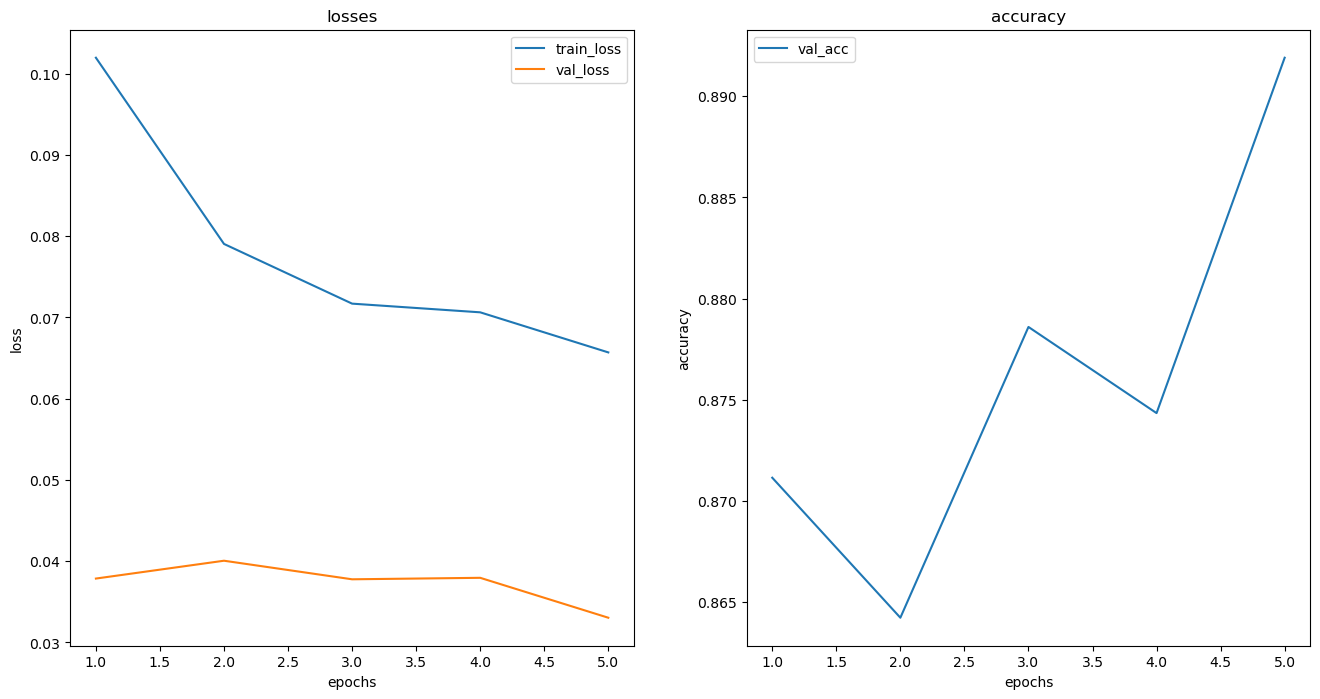

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

axs[0].set_title('losses')
axs[0].plot(list(range(1,5+1)), train_loss_TL, label="train_loss")
axs[0].plot(list(range(1,5+1)), val_loss_TL, label="val_loss")
axs[0].legend()
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")

axs[1].set_title('accuracy')
axs[1].plot(list(range(1,5+1)), acc_TL, label="val_acc")
axs[1].legend()
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")

plt.show()

## Вывод

Реализовал 3ю часть пайплайна распознавания лиц на двух метриках: Triplet loss и CE loss, а также реализовал рассчет IR метрики (TPR@FPR = 0.01). Triplet loss показал себя лучше, чем CE loss, но не критично. В целом было бы классно еще в процессе обучения считать IR метрику, но это крайне ресурсно затратно, так что это реализовать не получилось. К сожалению, не удалось доделать 1 и 2ю часть пайплайна из-за нехватки времени, но в целом получилась нейросеть, способная определять, один и тот же человек или нет, а также, способная классифицировать человека из данного датасета с Accuracy = 78 и 88% 